In [1]:
import torch
#from torch.autograd import Variable
from torchvision import models, datasets, transforms
from torch.utils.data import SubsetRandomSampler, TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import random
#import cv2
import matplotlib.pyplot as plt
#import argparse
from PIL import Image
#from model_mnist import Basic_CNN

In [2]:
%config IPCompleter.greedy = True
#random_seed = 0 #As randomness is a key part of this method, we don't want a seed
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
import numpy as np
def get_train_data_stats(train_data):
    # use np.concatenate to stick all the images together to form a 1600000 X 32 X 3 array\
    x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])
    print(x.shape)
    # calculate the mean and std along the (0, 1) axes
    train_mean = np.mean(x, axis=(0, 1))
    train_std = np.std(x, axis=(0, 1))
    print(train_mean, train_std)
    return train_mean, train_std

In [4]:
# load the training data
data_path = '~/IDS576/data'
train_data = datasets.CIFAR10(root=data_path, train=True, download=True)
train_mean, train_std = get_train_data_stats(train_data)

Files already downloaded and verified
(1600000, 32, 3)
[125.30691805 122.95039414 113.86538318] [62.99321928 62.08870764 66.70489964]


In [5]:
print(train_mean/255, train_std/255)

[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]


In [6]:
normalize = transforms.Normalize(
    mean = train_mean/255, 
    std = train_std/255)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
    ])
    
val_transform = transforms.Compose([   
    transforms.ToTensor(),
    normalize
    ])

#train_transform = transforms.Compose([transforms.ToTensor()])
    
#val_transform = transforms.Compose([transforms.ToTensor()])

In [7]:
# Download train and test data
data_path = '~/IDS576/data'
trainset = datasets.CIFAR10(root=data_path, train=True, download=True, transform=train_transform)
valset = datasets.CIFAR10(root=data_path, train=True, download=True, transform=val_transform)
testset = datasets.CIFAR10(root=data_path, train=False, download=True, transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
class CIFAR(nn.Module):
    
    def __init__(self):
        super(CIFAR, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.batchnorm1 = nn.BatchNorm2d(32, affine=False)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64, affine=False)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128, affine=False)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.dropout = nn.Dropout(p=.2)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.pool = nn.MaxPool2d(2, 2)
                             
    def forward(self, x):
        x = self.batchnorm1(self.conv1(x))
        x = self.pool(F.relu(x))
        x = self.batchnorm2(self.conv2(x))
        x = self.pool(F.relu(x))
        x = self.batchnorm3(self.conv3(x))
        x = self.pool(F.relu(x))
        x = x.view(-1, 128 * 4 * 4) 
        x = F.relu(self.fc1(x)) 
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [9]:
import torch.nn as nn
import torch
import numpy as np

class RFN(nn.Module):
    '''Wrapper class that takes any nn.Module based model and adds an RFN layer prior to all other layers.'''
    
    
    def __init__(self, model, mu=.1, sigma=.05, rfn_flag=True):
        super(RFN, self).__init__()
        self.model = model
        self.mu = mu
        self.sigma = sigma
        self.rfn_flag = rfn_flag
        self.shape_vals = None

    def forward(self, x):
        if self.rfn_flag:
            x = self.random_masks(x) * x
            x = self.model(x)
        else:
            x = self.model(x)
        return x
    
    
    def random_masks(self, x):
        # Set various shape values once to speed processing
        if self.shape_vals is None:
            self.shape_vals = x.size(), x[0].size(), x[0].nelement()
            #print(self.shape_vals)

        # Create ones array of size (batch,channel,horiz,vert)
        masks = np.ones(self.shape_vals[0])

        # Create random masks for each sample in the batch
        for mask in masks:
            zero_cnt = np.absolute(int(np.ceil((self.sigma * np.random.randn() + self.mu) * self.shape_vals[2])))
            zero_idx = np.random.choice(self.shape_vals[2], zero_cnt, replace=False)
            mask.reshape(self.shape_vals[2])[zero_idx] = 0
            mask.reshape(self.shape_vals[1])
        return torch.tensor(masks, dtype=torch.float, device=device)

In [10]:
def fgsm_batch(net, orig, eps=15):
    '''Given a pytorch CNN model, original image as tensor, and value for epsilon, create adversarial sample
    using fast gradient sign method (FGSM) described in arXiv:1412.6572v3'''
    # Create input tensor from original image, unsqeezing by a dim to account for model expected batch dim
    # float cast is likely not needed after normalization, but as float is required for cuda execution,
    # it's best to ensure float data
    inp = orig.float().clone().detach().to(device).requires_grad_(True)
    
    # Make prediction prior to attack to use in calulating gradients
    prior_out = net(inp)
    prior_pred = torch.argmax(prior_out)
    
    # Use prediction vector to compute loss and then compute gradients from loss to use in attack
    loss = criterion(prior_out, prior_pred.unsqueeze(0))
    loss.backward()
    
    # Actual FSGM method
    #print(orig.min(), orig.max())
    inp.data = inp.data + ((eps/255.0) * torch.sign(inp.grad.data))
    inp.data = inp.data.clamp(min=orig.min(), max=orig.max())
    #print(inp.min(), inp.max())
    '''
    # Predict on attack sample
    post_pred = torch.argmax(net(inp).data)
    
    # Create perturbation mask
    perturbation = torch.empty_like(orig)
    adv = inp.data.cpu()[0]
    perturbation = adv - orig'''
    
    return inp

In [65]:
def fgsm_sample(net, orig, eps=10):
    '''Given a pytorch CNN model, original image as tensor, and value for epsilon, create adversarial sample
    using fast gradient sign method (FGSM) described in arXiv:1412.6572v3'''
    # Create input tensor from original image, unsqeezing by a dim to account for model expected batch dim
    # float cast is likely not needed after normalization, but as float is required for cuda execution,
    # it's best to ensure float data
    inp = orig.unsqueeze(0).float().clone().detach().to(device).requires_grad_(True)
    # Make prediction prior to attack to use in calulating gradients
    prior_out = net(inp)
    prior_pred = torch.argmax(prior_out)
    # Use prediction vector to compute loss and then compute gradients from loss to use in attack
    loss = criterion(prior_out, prior_pred.unsqueeze(0))
    loss.backward()
    print('AFTER BACKPROP', loss.grad_fn)
    # Actual FSGM method
    #print(orig.min(), orig.max())
    print(inp, inp.grad.data)
    inp.data = inp.data + ((eps/255.0) * torch.sign(inp.grad.data))
    inp.data = inp.data.clamp(min=orig.min(), max=orig.max())
    #print(inp.min(), inp.max())
    
    # Predict on attack sample
    post_pred = torch.argmax(net(inp).data)
    
    # Create perturbation mask
    perturbation = torch.empty_like(orig)
    adv = inp.data.cpu()[0]
    perturbation = adv - orig
    return inp, perturbation, prior_pred, post_pred

In [66]:
dir(orig.grad)

['__bool__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [67]:
orig = trainset[0][0]
result = fgsm_sample(cifar_ref, orig, eps=10)
dir(result[0].grad)

AFTER BACKPROP <NllLossBackward object at 0x7fbb76c69198>
tensor([[[[-1.0526e+00, -1.3066e+00, -1.1955e+00,  ...,  5.1899e-01,
            4.2375e-01,  3.6025e-01],
          [-1.7352e+00, -1.9892e+00, -1.7035e+00,  ..., -3.6622e-02,
           -1.0012e-01, -5.2496e-02],
          [-1.5923e+00, -1.7352e+00, -1.2114e+00,  ..., -1.1600e-01,
           -8.4246e-02, -2.5887e-01],
          ...,
          [ 1.3127e+00,  1.2016e+00,  1.1540e+00,  ...,  5.5074e-01,
           -1.1002e+00, -1.1479e+00],
          [ 8.6824e-01,  7.5711e-01,  9.6349e-01,  ...,  9.3174e-01,
           -4.4936e-01, -6.7161e-01],
          [ 8.2061e-01,  6.7774e-01,  8.5236e-01,  ...,  1.4397e+00,
            4.0787e-01, -3.6622e-02]],

         [[-9.8167e-01, -1.2394e+00, -1.2072e+00,  ...,  1.4575e-01,
            3.3011e-02,  1.6905e-02],
          [-1.6581e+00, -1.9802e+00, -1.8514e+00,  ..., -5.6291e-01,
           -6.4344e-01, -5.7902e-01],
          [-1.5937e+00, -1.8675e+00, -1.5454e+00,  ..., -6.2733e-01,


['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__cuda_array_interface__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__idiv__',
 '__ilshift__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rfloordiv__',
 '__rmul__',
 '__rpow__',
 '__rshift__',
 '__rsub__',
 '__rtrued

In [64]:
def denormalize(tensor):
    denorm_tensor = tensor.clone().detach()
    for t, mean, std in zip(denorm_tensor, train_mean, train_std):
        t.mul_(std).add_(mean)
    return denorm_tensor.int().clamp(min=0, max=255)

def visualize_attack(orig, inp, perturbation, prior_pred, post_pred, label):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    fig.suptitle(f'FGSM sample with epsilon = {eps}', y=.8)
    ax[0].set_title(f'True: {label}, Pred {prior_pred}')
    ax[0].imshow(denormalize(orig).numpy().transpose(1,2,0))
    ax[1].set_title(f'Perturbation')
    ax[1].imshow(denormalize(perturbation).numpy().transpose(1,2,0))
    ax[2].set_title(f'Adv Pred: {post_pred}')
    ax[2].imshow(denormalize(inp.cpu().squeeze()).numpy().transpose(1,2,0))

In [28]:
sample_idx = 1000

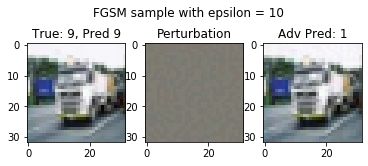

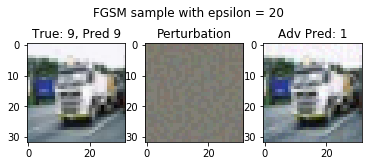

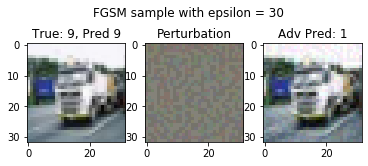

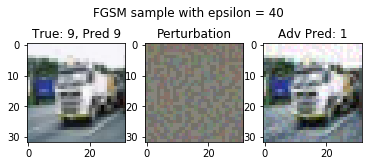

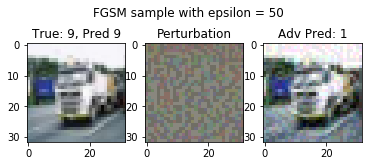

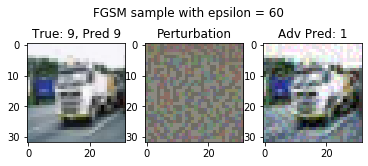

In [29]:
# FGSM vs CIFAR with no RFN
num_samples = 1
trainlen = len(trainset)
eps_list = [10,20,30,40,50,60]
mu = 0

cifar_ref = CIFAR()
cifar_ref.to(device)
cifar_ref.load_state_dict(torch.load(f'./models/CIFAR_rfn_{mu}.pth'))
cifar_ref.eval()

for i in range(num_samples):
    #sample_idx = int(random.random()*trainlen)
    for eps in eps_list:
        orig = trainset[sample_idx][0] #3x32x32
        label = trainset[sample_idx][1]
        inp, perturbation, prior_pred, post_pred = fgsm_sample(cifar_ref, orig, eps=eps)
        visualize_attack(orig, inp, perturbation, prior_pred, post_pred, label)


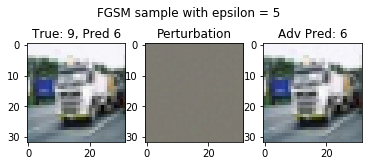

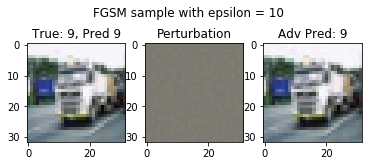

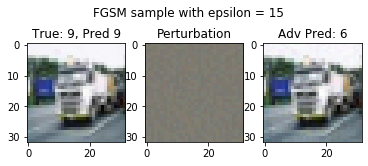

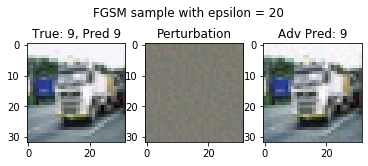

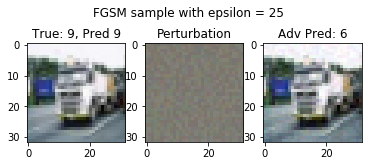

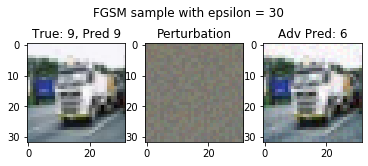

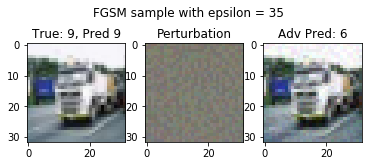

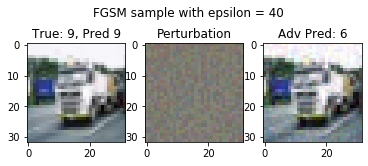

In [30]:
# FGSM vs RFN Net
num_samples = 1
trainlen = len(trainset)
eps_list = [5,10,15,20,25,30,35,40]
mu = 0.4

cifar_ref = CIFAR()
cifar_ref.to(device)
cifar_ref.load_state_dict(torch.load(f'./models/CIFAR_rfn_{mu}.pth'))
cifar_ref.eval()
rfn_wrapper = RFN(cifar_ref, mu=mu, sigma=0, rfn_flag=True)

for i in range(num_samples):
    #sample_idx = int(random.random()*trainlen)
    
    for eps in eps_list:
        orig = trainset[sample_idx][0] #3x32x32
        label = trainset[sample_idx][1]
        inp, perturbation, prior_pred, post_pred = fgsm_sample(rfn_wrapper, orig, eps=eps)
        visualize_attack(orig, inp, perturbation, prior_pred, post_pred, label)

In [11]:
def evaluate(net, dataloader, eps=15, adv=False):
    correct = 0
    count = 0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        if adv:
            inputs = fgsm_batch(net, inputs, eps = eps)
        preds = net(inputs)
        if torch.argmax(preds) == labels:
            correct += 1.0
        count += 1.0
        if not i % 5000:
            print(f'Sample: {i}, Running Accuracy: {(correct/count):5.3f}')
    acc = correct/count
    print(f'Accuracy over {int(count)} samples: {acc:5.3f}')
    return acc
        

In [12]:
# Create accuracy dictionary
from collections import defaultdict
accs_no_fsgm = defaultdict(list)
accs_fsgm = defaultdict(list)

In [13]:
epsilons = np.array([10, 20, 30, 40])
epsilons/255

array([0.03921569, 0.07843137, 0.11764706, 0.15686275])

In [31]:
# load CIFAR models
train_dl = DataLoader(trainset, batch_size=1)

rfn_mu_vals = [0, .1, .2, .3, .4, .5]

#epsilons = [10, 20, 30, 40]
epsilons = [40]

# Evaluate pretrained CIFAR RFN CNNs with and without FSGM attack 
for eps in epsilons:
    for adv in [False, True]:
        for i, mu in enumerate(rfn_mu_vals):
            cifar_rfn = CIFAR()
            rfn_wrapper = RFN(cifar_rfn, mu=mu, sigma=0, rfn_flag=True)
            cifar_rfn.load_state_dict(torch.load(f'./models/CIFAR_rfn_{mu}.pth'))
            cifar_rfn.to(device)
            cifar_rfn.eval()
            criterion = nn.CrossEntropyLoss()
            if adv:
                print(f'Evaluate CIFAR RFN at epsilon={eps}, mu={mu}:')
                accs_fsgm[mu] = evaluate(rfn_wrapper, train_dl, eps=eps, adv=adv)
            else:
                print(f'Evaluate CIFAR RFN without FSGM, mu={mu}:')
                accs_no_fsgm[mu] = evaluate(rfn_wrapper, train_dl, eps=eps, adv=adv)

Evaluate CIFAR RFN without FSGM, mu=0:
Sample: 0, Running Accuracy: 1.000
Sample: 5000, Running Accuracy: 0.854
Sample: 10000, Running Accuracy: 0.850
Sample: 15000, Running Accuracy: 0.845
Sample: 20000, Running Accuracy: 0.846
Sample: 25000, Running Accuracy: 0.846
Sample: 30000, Running Accuracy: 0.849
Sample: 35000, Running Accuracy: 0.848
Sample: 40000, Running Accuracy: 0.847
Sample: 45000, Running Accuracy: 0.847
Accuracy over 50000 samples: 0.847
Evaluate CIFAR RFN without FSGM, mu=0.1:
Sample: 0, Running Accuracy: 1.000
Sample: 5000, Running Accuracy: 0.694
Sample: 10000, Running Accuracy: 0.694
Sample: 15000, Running Accuracy: 0.692
Sample: 20000, Running Accuracy: 0.692
Sample: 25000, Running Accuracy: 0.690
Sample: 30000, Running Accuracy: 0.692
Sample: 35000, Running Accuracy: 0.691
Sample: 40000, Running Accuracy: 0.691
Sample: 45000, Running Accuracy: 0.692
Accuracy over 50000 samples: 0.693
Evaluate CIFAR RFN without FSGM, mu=0.2:
Sample: 0, Running Accuracy: 1.000
Samp

In [33]:
print(f'MU\tCIFAR\tFSGM eps=40')

for mu in rfn_mu_vals:
    print(f'{mu}\t{accs_no_fsgm[mu]:5.3}\t{accs_fsgm[mu]:5.3}')
    

MU	CIFAR	FSGM eps=40
0	0.847	0.094
0.1	0.693	0.224
0.2	0.535	0.299
0.3	 0.41	0.301
0.4	0.315	0.262
0.5	0.235	0.214


The RFN addition clearly degraded the CIFAR network, as expected. That said, this degredation was much worse than reported in the paper, which may be due to differences in CNN architecture.

The evaluation of FSGM samples by the networks shows a clear degredation of performance, most notably on the CIFAR network without RFN applied going from .847 -> 0.094. The application of RFN immediately improved CNN performance vs FSGM attack at the cost of accuracy on regular samples. Further investigation is needed to determine best CNN architecture and level of RFN to maintain high performance while also mitigating impact of FSGM attack.

In [805]:

eval(basicnet, train_dl, adv=False)

Sample: 0, Running Accuracy: 1.000
Sample: 5000, Running Accuracy: 0.509
Sample: 10000, Running Accuracy: 0.505
Sample: 15000, Running Accuracy: 0.505
Sample: 20000, Running Accuracy: 0.501
Sample: 25000, Running Accuracy: 0.503
Sample: 30000, Running Accuracy: 0.506
Sample: 35000, Running Accuracy: 0.504
Sample: 40000, Running Accuracy: 0.504
Sample: 45000, Running Accuracy: 0.504
Accuracy over 50000 samples: 0.505


In [812]:
eval(basicnet, train_dl, adv=True)

Sample: 0, Running Accuracy: 0.000
Sample: 5000, Running Accuracy: 0.366
Sample: 10000, Running Accuracy: 0.371
Sample: 15000, Running Accuracy: 0.371
Sample: 20000, Running Accuracy: 0.373
Sample: 25000, Running Accuracy: 0.374
Sample: 30000, Running Accuracy: 0.376
Sample: 35000, Running Accuracy: 0.374
Sample: 40000, Running Accuracy: 0.374
Sample: 45000, Running Accuracy: 0.375
Accuracy over 50000 samples: 0.375


In [813]:
eval(rfnnet, train_dl, adv=False)

Sample: 0, Running Accuracy: 0.000
Sample: 5000, Running Accuracy: 0.558
Sample: 10000, Running Accuracy: 0.558
Sample: 15000, Running Accuracy: 0.553
Sample: 20000, Running Accuracy: 0.552
Sample: 25000, Running Accuracy: 0.553
Sample: 30000, Running Accuracy: 0.554
Sample: 35000, Running Accuracy: 0.551
Sample: 40000, Running Accuracy: 0.550
Sample: 45000, Running Accuracy: 0.551
Accuracy over 50000 samples: 0.552


In [814]:
eval(rfnnet, train_dl, adv=True)

Sample: 0, Running Accuracy: 0.000
Sample: 5000, Running Accuracy: 0.465
Sample: 10000, Running Accuracy: 0.475
Sample: 15000, Running Accuracy: 0.476
Sample: 20000, Running Accuracy: 0.475
Sample: 25000, Running Accuracy: 0.478
Sample: 30000, Running Accuracy: 0.477
Sample: 35000, Running Accuracy: 0.476
Sample: 40000, Running Accuracy: 0.474
Sample: 45000, Running Accuracy: 0.474
Accuracy over 50000 samples: 0.474


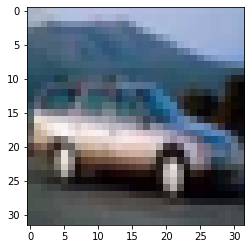

In [621]:
plt.imshow(denormalize(orig).numpy().transpose(1,2,0))

In [739]:
def random_mask(x, mu_p=.1, sig_p=.05):
    mask_prob = torch.tensor(sig_p * np.random.randn() + mu_p, device=device)
    print(mask_prob)
    zeros = torch.ceil(x.nelement()*mask_prob).int()
    print(zeros)
    mask = torch.ones(x.nelement())
    print(mask)
    mask[:zeros] = 0
    np.random.shuffle(mask.data)
    return mask.reshape(x.size()).float()

In [396]:
# prediction before attack
inp = Variable(orig.to(device).float().unsqueeze(0), requires_grad=True)

out = net(inp)
pred = np.argmax(out.data.cpu().numpy())
print(f'Prediction before attack: {pred} vs True: {label}')
loss = criterion(out, Variable(torch.Tensor([float(pred)]).to(device).long()))

# compute gradients
loss.backward()
#Create empty tensor of same shape as input image


eps = 1

# this is it, this is the method
inp.data = inp.data + ((eps/255.0) * torch.sign(inp.grad.data))
inp.data = inp.data.clamp(min=-1, max=1)
#inp.grad.data.zero_() # unnecessary

Prediction before attack: 1 vs True: 1


In [397]:
# predict on the adversarial image
pred_adv = np.argmax(net(inp).data.cpu().numpy())
print(f'After attack: eps {eps} True Label: {label} Post Label: {pred_adv}')

After attack: eps 1 True Label: 1 Post Label: 1


In [398]:
perturbation = torch.empty_like(orig)
adv = inp.data.cpu()[0]
perturbation = adv - orig

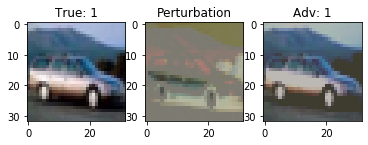

In [399]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].set_title(f'True: {label}')
ax[0].imshow(denormalize(orig).numpy().transpose(1,2,0))
ax[1].set_title(f'Perturbation')
ax[1].imshow(denormalize(perturbation).numpy().transpose(1,2,0))
ax[2].set_title(f'Adv: {pred_adv}')
ax[2].imshow(denormalize(inp.cpu().squeeze()).numpy().transpose(1,2,0))

In [298]:
# deprocess image
adv = inp.data.cpu().numpy()[0][0]
perturbation = adv-orig.numpy()
adv = (adv * std) + mean
adv = adv * 255.0
adv = np.clip(adv, 0, 255).astype(np.uint8)
perturbation = perturbation*255
perturbation = np.clip(perturbation, 0, 255).astype(np.uint8)

TypeError: Invalid shape (3, 32, 32) for image data

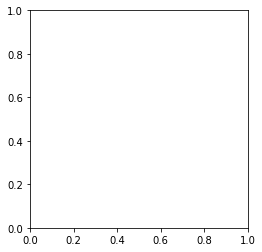

In [299]:
plt.imshow(adv)

In [42]:
!nvidia-smi

Wed Nov  6 15:19:57 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.27       Driver Version: 415.27       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0 Off |                  N/A |
| 34%   53C    P2    39W / 180W |   1064MiB /  8117MiB |      5%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  